In [3]:
import argparse
import numpy as np
import pandas as pd
import torch
from tabulate import tabulate
from torch.utils.data import DataLoader

from model import BertCustomBinaryClassifier
from utils.ensemble_utils import make_predictions
from utils.evaluate_metrics import evaluate_metrics
from utils.data_preprocessing import load_dataset

In [4]:
import logging
logging.getLogger("transforkmer_values.modeling_utils").setLevel(logging.ERROR)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", type=int, default=64, help="")
parser.add_argument("--max_length", type=int, default=200, help="")
args = parser.parse_args(args=[])

# **BERT Models**

In [7]:
threshold = 0.50
kmer_values = [3, 4, 5, 6]
model_date = "2025-02-27_V2"

results = []  # List to store results
train_predictions_list, test_predictions_list = [], []  # Lists for storing model predictions
train_labels_list, test_labels_list = [], []  # Lists for storing true labels

print(f"Threshold: {threshold}")
print(f"Identifier model date: {model_date}")

for kmer in kmer_values:

    args.model_path = f"./outputs/identifier_models/{model_date}/{kmer}-mer"
    args.test_data_path = f"./data/enhancer_identification/{kmer}-mer_identification_test.txt"
    args.train_data_path = f"./data/enhancer_identification/{kmer}-mer_identification_train.txt"

    # Load training and test datasets
    train_dataset = load_dataset(args, validation=False)
    test_dataset = load_dataset(args, validation=True)

    # Initialize data loaders for batch processing
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

    # Model
    model = BertCustomBinaryClassifier.from_pretrained(args.model_path, num_labels=1).to(device)

    # Prediction on training datasets
    train_predictions, train_labels = make_predictions(model, train_dataloader, kmer=kmer)
    train_predictions_list.append(train_predictions)
    train_labels_list.append(train_labels)

    acc, sn, sp, mcc, auc = evaluate_metrics(train_predictions, train_labels)
    results.append({"k-mer": kmer, "Dataset": "Train", "Accuracy": acc, "Sensitivity": sn, "Specificity": sp, "MCC": mcc, "AUC": auc})

    # Prediction on test (independent) dataset
    test_predictions, test_labels = make_predictions(model, test_dataloader, kmer=kmer)
    test_predictions_list.append(test_predictions)
    test_labels_list.append(test_labels)

    acc, sn, sp, mcc, auc = evaluate_metrics(test_predictions, test_labels)
    results.append({"k-mer": kmer, "Dataset": "Test", "Accuracy": acc, "Sensitivity": sn, "Specificity": sp, "MCC": mcc, "AUC": auc})

Threshold: 0.5
Identifier model date: 2025-02-27_V2


In [8]:
results_df = pd.DataFrame(results, columns=["k-mer", "Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"])

# Split into training and test
training_df = results_df[results_df['Dataset'].str.contains("Train")]
test_df = results_df[results_df['Dataset'].str.contains("Test")]

print("Training results:")
print(tabulate(training_df, headers="keys", tablefmt="grid", showindex=False, floatfmt=".4f"))

print("\nTest results:")
print(tabulate(test_df, headers="keys", tablefmt="grid", showindex=False, floatfmt=".4f"))

Training results:
+---------+-----------+------------+---------------+---------------+--------+--------+
|   k-mer | Dataset   |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+=========+===========+============+===============+===============+========+========+
|       3 | Train     |     0.8999 |        0.8477 |        0.9522 | 0.8043 | 0.9015 |
+---------+-----------+------------+---------------+---------------+--------+--------+
|       4 | Train     |     0.9067 |        0.8504 |        0.9629 | 0.8185 | 0.9174 |
+---------+-----------+------------+---------------+---------------+--------+--------+
|       5 | Train     |     0.8854 |        0.8194 |        0.9515 | 0.7777 | 0.9045 |
+---------+-----------+------------+---------------+---------------+--------+--------+
|       6 | Train     |     0.8757 |        0.7978 |        0.9535 | 0.7606 | 0.8962 |
+---------+-----------+------------+---------------+---------------+--------+--------+

Test results:
+---------

In [9]:
# Initialize variables
best_test_acc = 0.0
best_threshold = 0.0

# Weights for ensemble 
weights = np.array(results_df[results_df['Dataset'].str.contains("Train")]['Accuracy'])

# Normalize weights to ensure they sum to 1
weights /= np.sum(weights)

# Define threshold values to test
threshold_values = np.arange(0.40, 0.81, 0.001)

# Variables to store the best metrics
best_train_acc, best_train_sn, best_train_sp, best_train_mcc, best_train_auc = 0, 0, 0, 0, 0
best_test_acc, best_test_sn, best_test_sp, best_test_mcc, best_test_auc = 0, 0, 0, 0, 0

# Loop through threshold values
for threshold in threshold_values:
    # Weighted average for training predictions
    train_predictions_weighted = np.average(train_predictions_list, axis=0, weights=weights)
    train_labels_average = np.array(train_labels_list).mean(axis=0)
    
    # Evaluate training metrics
    train_acc, train_sn, train_sp, train_mcc, train_auc = evaluate_metrics(
        train_predictions_weighted, train_labels_average, threshold=threshold
    )

    # Weighted average for test predictions
    test_predictions_weighted = np.average(test_predictions_list, axis=0, weights=weights)
    test_labels_average = np.array(test_labels_list).mean(axis=0)

    # Evaluate test metrics
    test_acc, test_sn, test_sp, test_mcc, test_auc = evaluate_metrics(
        test_predictions_weighted, test_labels_average, threshold=threshold
    )
    
    # Check if current threshold yields the best test accuracy or compare MCC when accuracies are equal
    if (test_acc > best_test_acc) or (test_acc == best_test_acc and train_acc > best_train_acc):
        best_test_acc = test_acc
        best_threshold = threshold

        # Store the best metrics
        best_train_acc, best_train_sn, best_train_sp, best_train_mcc, best_train_auc = train_acc, train_sn, train_sp, train_mcc, train_auc
        best_test_acc, best_test_sn, best_test_sp, best_test_mcc, best_test_auc = test_acc, test_sn, test_sp, test_mcc, test_auc

# Print the best threshold and corresponding test accuracy
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")

# Update results table with the best weighted ensemble metrics
ensemble_results_weighted = [
    ["Weighted Ensemble Training", f"{best_train_acc:.4f}", f"{best_train_sn:.4f}", f"{best_train_sp:.4f}", f"{best_train_mcc:.4f}", f"{best_train_auc:.4f}"],
    ["Weighted Ensemble Testing", f"{best_test_acc:.4f}", f"{best_test_sn:.4f}", f"{best_test_sp:.4f}", f"{best_test_mcc:.4f}", f"{best_test_auc:.4f}"]
]
ensemble_results_df_weighted = pd.DataFrame(ensemble_results_weighted, columns=["Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"])

# Display results
print(tabulate(ensemble_results_df_weighted, headers="keys", tablefmt="grid", showindex=False, floatfmt=".4f"))
threshold = best_threshold


Best Threshold: 0.4890
Best Test Accuracy: 0.8275
+----------------------------+------------+---------------+---------------+--------+--------+
| Dataset                    |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+============================+============+===============+===============+========+========+
| Weighted Ensemble Training |     0.9097 |        0.8612 |        0.9582 | 0.8233 | 0.9269 |
+----------------------------+------------+---------------+---------------+--------+--------+
| Weighted Ensemble Testing  |     0.8275 |        0.7650 |        0.8900 | 0.6602 | 0.8530 |
+----------------------------+------------+---------------+---------------+--------+--------+


In [10]:
# Calculate individual model scores for each sample
individual_model_scores = []
for i, kmer in enumerate(kmer_values):
    for sample_idx in range(len(test_predictions_list[i])):
        individual_model_scores.append({
            "Sample": sample_idx + 1,
            "k-mer": kmer,
            "Score": test_predictions_list[i][sample_idx]
        })

# Calculate ensemble model scores
ensemble_test_predictions = np.array(test_predictions_list).mean(axis=0)
for sample_idx in range(len(ensemble_test_predictions)):
    individual_model_scores.append({
        "Sample": sample_idx + 1,
        "k-mer": "Ensemble",
        "Score": ensemble_test_predictions[sample_idx]
    })

# Convert to DataFrame
individual_model_scores_df = pd.DataFrame(individual_model_scores)

# Reshape DataFrame to have each sample as a row, and each model as a column
pivot_df = individual_model_scores_df.pivot(index="Sample", columns="k-mer", values="Score")
pivot_df.reset_index(inplace=True)

# Adding 'Label' and 'Prediction' columns
pivot_df["Label"] = test_labels_list[0]  
pivot_df["Prediction"] = (pivot_df["Ensemble"] >= threshold).astype(int)  # Converting ensemble scores to binary predictions

# Rename columns to match desired format
# Assuming you have 4 k-mer values in kmer_values list
column_mapping = {kmer: str(i + 3) for i, kmer in enumerate(kmer_values)}
pivot_df.rename(columns=column_mapping, inplace=True)

# Add 'Correct' column
pivot_df["Correct"] = pivot_df["Label"] == pivot_df["Prediction"]

# Display the table
print(tabulate(pivot_df, headers="keys", tablefmt="grid", showindex=False, floatfmt=".4f"))

+----------+--------+--------+--------+--------+------------+---------+--------------+-----------+
|   Sample |      3 |      4 |      5 |      6 |   Ensemble |   Label |   Prediction | Correct   |
+==========+========+========+========+========+============+=========+==============+===========+
|        1 | 0.2675 | 0.1379 | 0.1561 | 0.2834 |     0.2112 |       0 |            0 | True      |
+----------+--------+--------+--------+--------+------------+---------+--------------+-----------+
|        2 | 0.2675 | 0.1379 | 0.1561 | 0.2834 |     0.2112 |       0 |            0 | True      |
+----------+--------+--------+--------+--------+------------+---------+--------------+-----------+
|        3 | 0.2678 | 0.1379 | 0.8363 | 0.7124 |     0.4886 |       0 |            0 | True      |
+----------+--------+--------+--------+--------+------------+---------+--------------+-----------+
|        4 | 0.2676 | 0.1379 | 0.1561 | 0.2834 |     0.2112 |       0 |            0 | True      |
+---------

In [11]:
threshold = round(threshold, 4)
print(f"Threshold: {threshold}\n")

Threshold: 0.489



In [12]:
# Calculate counts of correct and incorrect predictions for each label
label_counts = pivot_df.groupby(["Label", "Correct"]).size().unstack(fill_value=0)

# Display the counts
print(label_counts)

# Calculate incorrect predictions for each k-mer model
incorrect_counts = pivot_df[["Label"]].copy()
for kmer, col_name in column_mapping.items():
    incorrect_counts[col_name] = pivot_df["Label"] != (pivot_df[col_name] >= threshold).astype(int)

# Split DataFrame into two separate DataFrames based on labels
label_0_df = pivot_df[pivot_df["Label"] == 0]
label_1_df = pivot_df[pivot_df["Label"] == 1]

# Calculate incorrect predictions for each k-mer model for both labels separately
incorrect_counts_label_0 = label_0_df[["Label"]].copy()
incorrect_counts_label_1 = label_1_df[["Label"]].copy()

for kmer, col_name in column_mapping.items():
    incorrect_counts_label_0[col_name] = label_0_df["Label"] != (label_0_df[col_name] >= threshold).astype(int)
    incorrect_counts_label_1[col_name] = label_1_df["Label"] != (label_1_df[col_name] >= threshold).astype(int)

# Sum incorrect predictions for each k-mer model for both labels separately
incorrect_counts_sum_label_0 = incorrect_counts_label_0.sum(axis=0)[1:]
incorrect_counts_sum_label_1 = incorrect_counts_label_1.sum(axis=0)[1:]

# Combine the incorrect predictions into a single DataFrame
combined_incorrect_counts_df = pd.DataFrame({
    "Model": list(incorrect_counts_sum_label_0.index),
    "Incorrect Predictions (Label 0)": incorrect_counts_sum_label_0.values,
    "Incorrect Predictions (Label 1)": incorrect_counts_sum_label_1.values
})

# Add a sum row at the end
sum_row = pd.DataFrame({
    "Model": ["Sum"],
    "Incorrect Predictions (Label 0)": [incorrect_counts_sum_label_0.sum()],
    "Incorrect Predictions (Label 1)": [incorrect_counts_sum_label_1.sum()]
})

combined_incorrect_counts_df = pd.concat([combined_incorrect_counts_df, sum_row], ignore_index=True)

# Add a sum column for the rows
combined_incorrect_counts_df["Sum"] = combined_incorrect_counts_df["Incorrect Predictions (Label 0)"] + combined_incorrect_counts_df["Incorrect Predictions (Label 1)"]

# Display the combined incorrect predictions counts
print("\nCombined incorrect predictions counts:")
print(tabulate(combined_incorrect_counts_df, headers="keys", tablefmt="grid", showindex=False))

Correct  False  True 
Label                
0           23    177
1           47    153

Combined incorrect predictions counts:
+---------+-----------------------------------+-----------------------------------+-------+
| Model   |   Incorrect Predictions (Label 0) |   Incorrect Predictions (Label 1) |   Sum |
+=========+===================================+===================================+=======+
| 3       |                                33 |                                48 |    81 |
+---------+-----------------------------------+-----------------------------------+-------+
| 4       |                                22 |                                58 |    80 |
+---------+-----------------------------------+-----------------------------------+-------+
| 5       |                                31 |                                49 |    80 |
+---------+-----------------------------------+-----------------------------------+-------+
| 6       |                                2

## **Venn Diagram**

In [13]:
# Initialize the dictionary to store correct prediction indices
correct_predictions_dict = {}

# Iterate through kmer values and corresponding predictions and labels
for kmer, predictions, labels in zip(kmer_values, test_predictions_list, test_labels_list):
    # Convert predictions to binary labels
    binary_predictions = (np.array(predictions) > threshold).astype(int)
    
    # Compare binary predictions with true labels to determine correctness
    correct_indices = {index for index, (predicted, true) in enumerate(zip(binary_predictions.flatten(), labels)) if predicted == true}
    
    # Store the set of correct indices in the dictionary with kmer as string
    correct_predictions_dict[f"{kmer}-mer"] = correct_indices

print(f"threshold: {threshold}")
print(correct_predictions_dict)

threshold: 0.489
{'3-mer': {0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 60, 61, 63, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 141, 142, 144, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 173, 174, 175, 177, 180, 181, 182, 183, 184, 185, 186, 188, 189, 191, 194, 195, 196, 197, 198, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 218, 219, 220, 221, 222, 224, 225, 227, 228, 229, 230, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 25

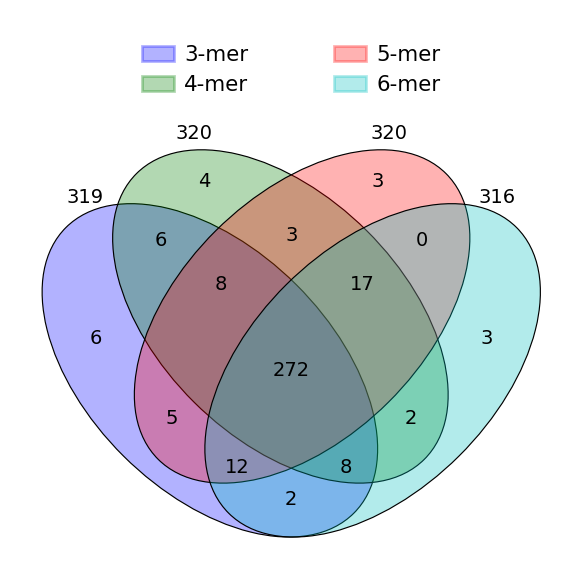

In [66]:
from venny4py.venny4py import *
venny4py(sets=correct_predictions_dict, out='analysis/venn/identifier', ext='pdf')

# **Machine Learning Models**

In [15]:
from sklearn.ensemble import  ExtraTreesClassifier

In [16]:
# Prepare meta-features for training and testing
train_meta_features = np.column_stack(train_predictions_list)
test_meta_features = np.column_stack(test_predictions_list)

train_labels = train_labels_list[0]     
test_labels = test_labels_list[0]

In [17]:
model = ExtraTreesClassifier(n_estimators=1000, random_state=42)

threshold = 0.88   

# Train the Stacking Classifier on the training set
model.fit(train_meta_features, train_labels)

# Meta-model predictions on the validation set
train_predictions_et = model.predict_proba(train_meta_features)[:, 1]
test_predictions_et = model.predict_proba(test_meta_features)[:, 1]

train_acc, train_sn, train_sp, train_mcc, train_auc = evaluate_metrics(train_predictions_et, train_labels, threshold=threshold)
test_acc, test_sn, test_sp, test_mcc, test_auc = evaluate_metrics(test_predictions_et, test_labels, threshold=threshold)

# Display results in table using tabulate
results = [["Train", train_acc, train_sn, train_sp, train_mcc, train_auc], ["Test", test_acc, test_sn, test_sp, test_mcc, test_auc]]

headers = ["Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"]

print(tabulate(results, headers=headers, tablefmt="grid", floatfmt=".4f"))

+-----------+------------+---------------+---------------+--------+--------+
| Dataset   |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+===========+============+===============+===============+========+========+
| Train     |     1.0000 |        1.0000 |        1.0000 | 1.0000 | 1.0000 |
+-----------+------------+---------------+---------------+--------+--------+
| Test      |     0.8350 |        0.7500 |        0.9200 | 0.6799 | 0.8652 |
+-----------+------------+---------------+---------------+--------+--------+


# **Plots**

In [18]:
# train_predictions = train_predictions_weighted
# test_predictions = test_predictions_weighted
train_predictions = train_predictions_et
test_predictions = test_predictions_et

In [19]:
# Create the directory if it does not exist
output_folder = "outputs/plots"
os.makedirs(output_folder, exist_ok=True)

## **ROC Curve**

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

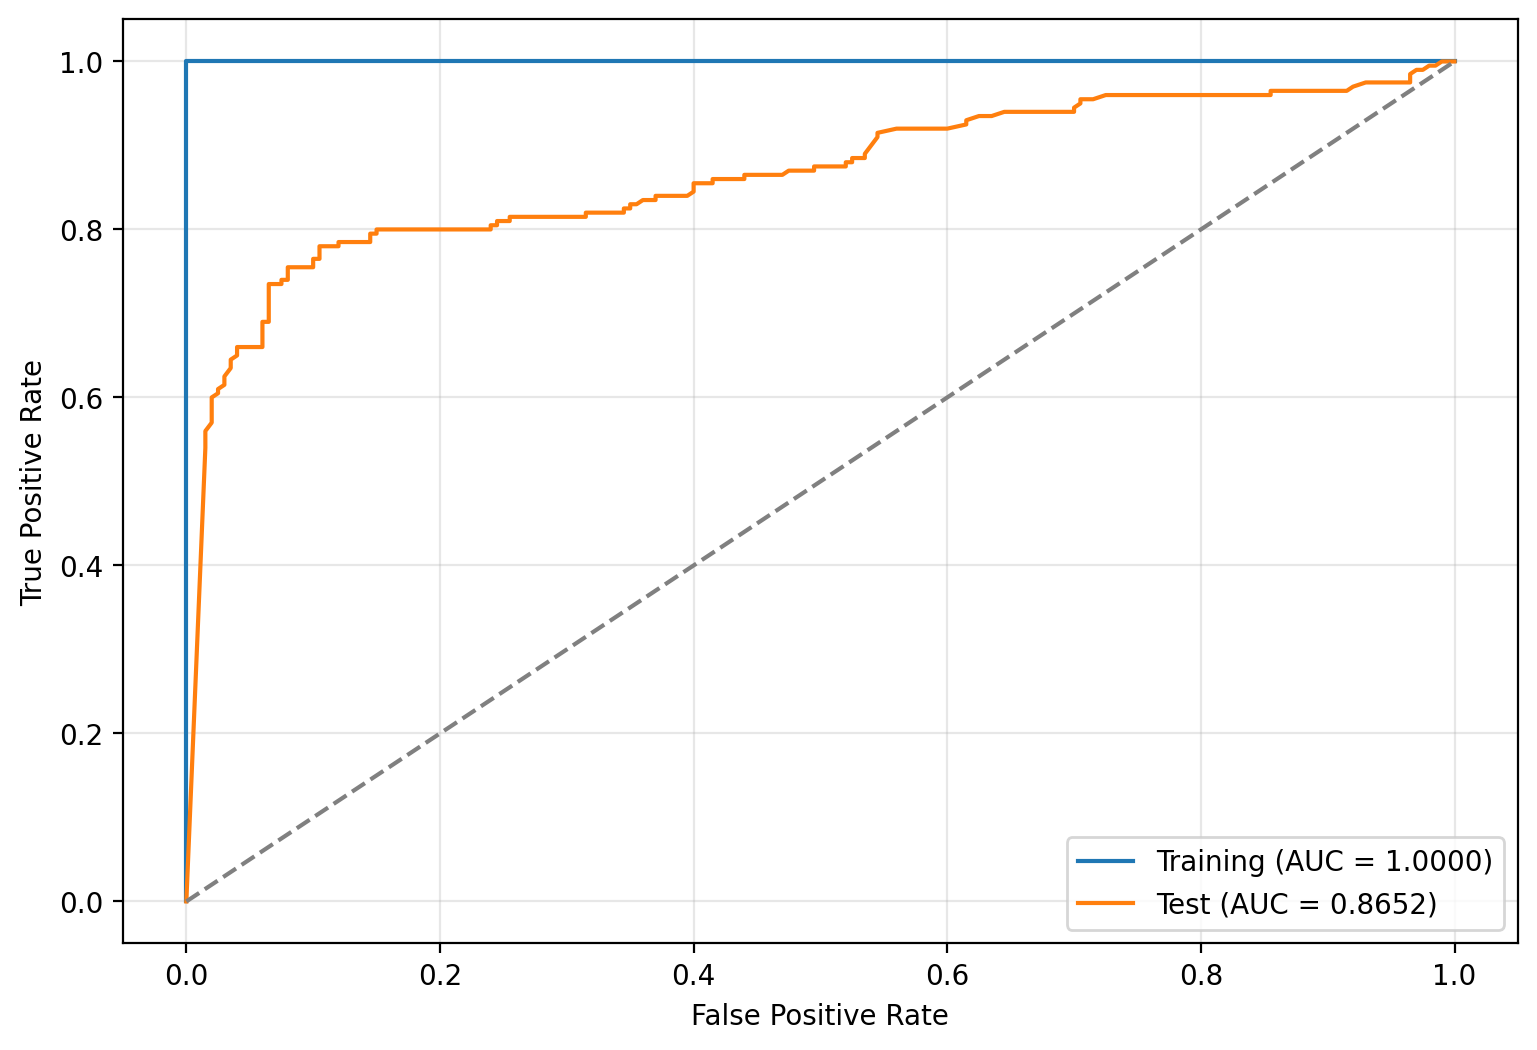

In [43]:
# Function to plot ROC curve
def plot_single_roc_curve(predictions, labels, dataset_name):
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{dataset_name} (AUC = {roc_auc:.4f})")


# Plot ROC curves for training and testing datasets
plt.figure(figsize=(9, 6))

# Training ROC Curve
plot_single_roc_curve(train_predictions, train_labels, "Training")

# Testing ROC Curve
plot_single_roc_curve(test_predictions, test_labels, "Test")

# Plot settings
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line for random guessing
# plt.xlim([-0.02, 1.02])
# plt.ylim([-0.02, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

output_folder = "outputs/plots"
plt.savefig(f"{output_folder}/layer_1_roc_curves.pdf", format="pdf", bbox_inches='tight')

plt.show()

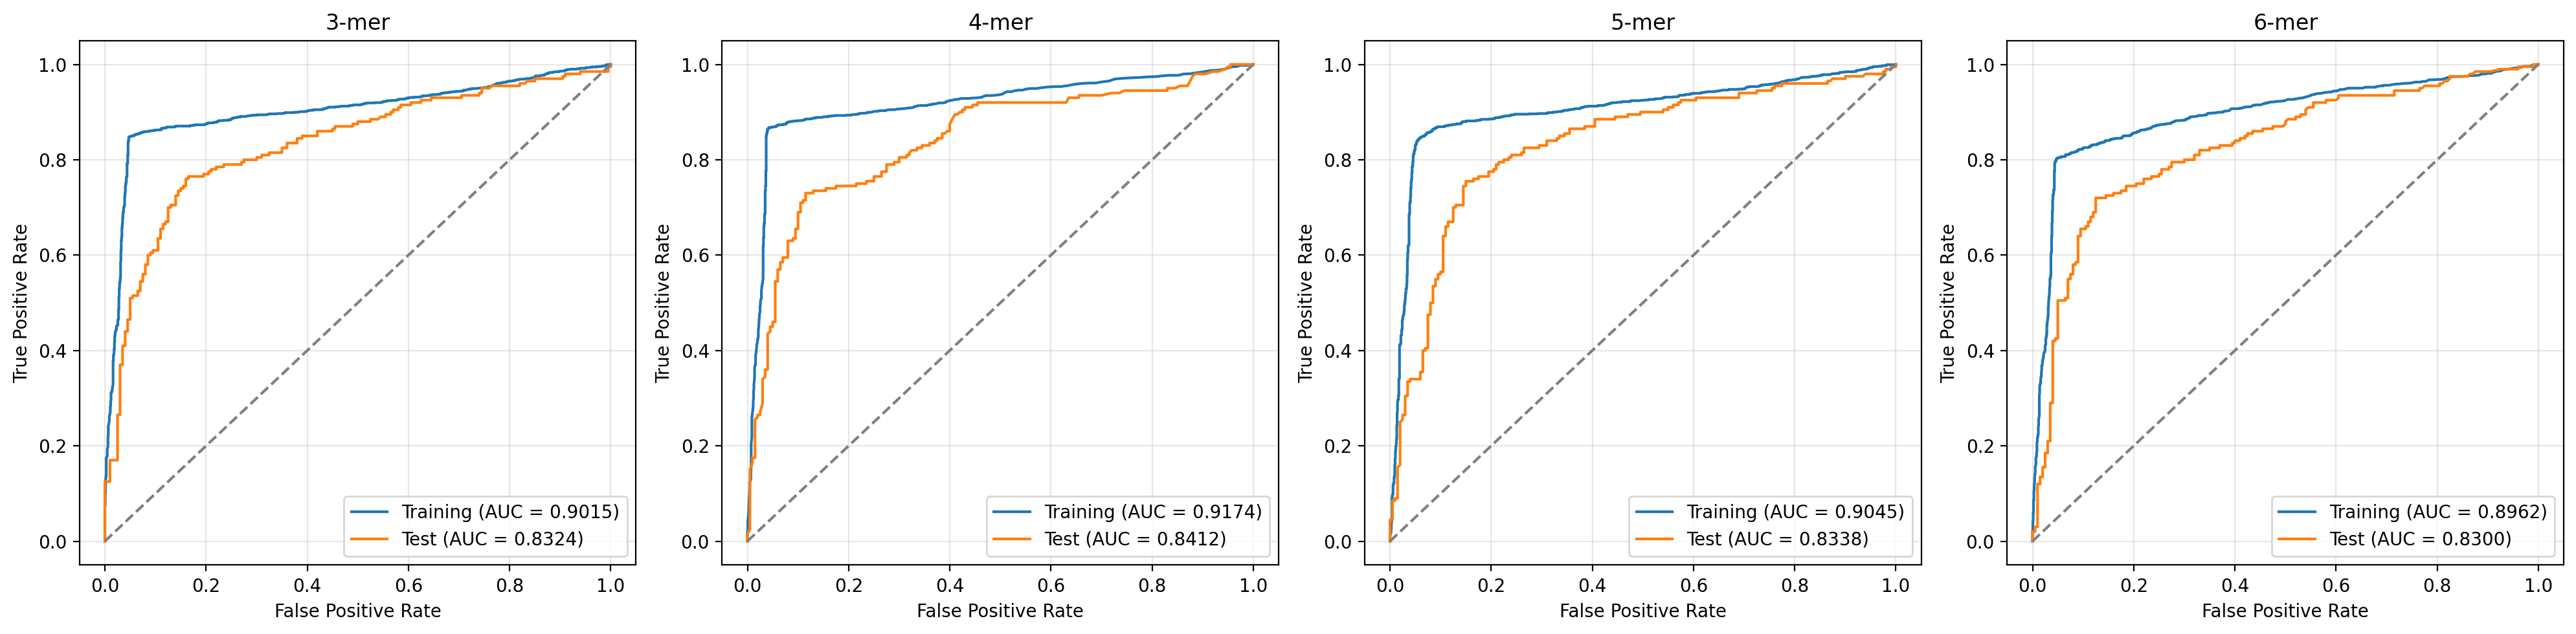

In [61]:
def plot_roc_curve(ax, predictions_train, labels_train, predictions_test, labels_test, k):
    fpr_train, tpr_train, _ = roc_curve(labels_train, predictions_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    ax.plot(fpr_train, tpr_train, label=f"Training (AUC = {roc_auc_train:.4f})")

    fpr_test, tpr_test, _ = roc_curve(labels_test, predictions_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    ax.plot(fpr_test, tpr_test, label=f"Test (AUC = {roc_auc_test:.4f})")

    ax.plot([0, 1], [0, 1], color="gray", linestyle="--")
    # ax.set_xlim([-0.02, 1.02])
    # ax.set_ylim([-0.02, 1.02])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{k}-mer")
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)


num_kmer_values = len(kmer_values)
cols = 4
rows = (num_kmer_values + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, mer in enumerate(kmer_values):
    kmer_train_predictions = train_predictions_list[i]
    kmer_train_labels = train_labels_list[i]
    kmer_test_predictions = test_predictions_list[i]
    kmer_test_labels = test_labels_list[i]

    plot_roc_curve(axes[i], kmer_train_predictions, kmer_train_labels, kmer_test_predictions, kmer_test_labels, mer)

for j in range(num_kmer_values, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig(f"{output_folder}/layer_1_kmer_roc_curves.pdf", format="pdf", bbox_inches='tight')
plt.show()

## **Precision-Recall Curve**

In [23]:
# Calculate precision and recall for training data
precision_train, recall_train, _ = precision_recall_curve(train_labels, train_predictions)
average_precision_train = average_precision_score(train_labels, train_predictions)

# Calculate precision and recall for test data
precision_test, recall_test, _ = precision_recall_curve(test_labels, test_predictions)
average_precision_test = average_precision_score(test_labels, test_predictions)

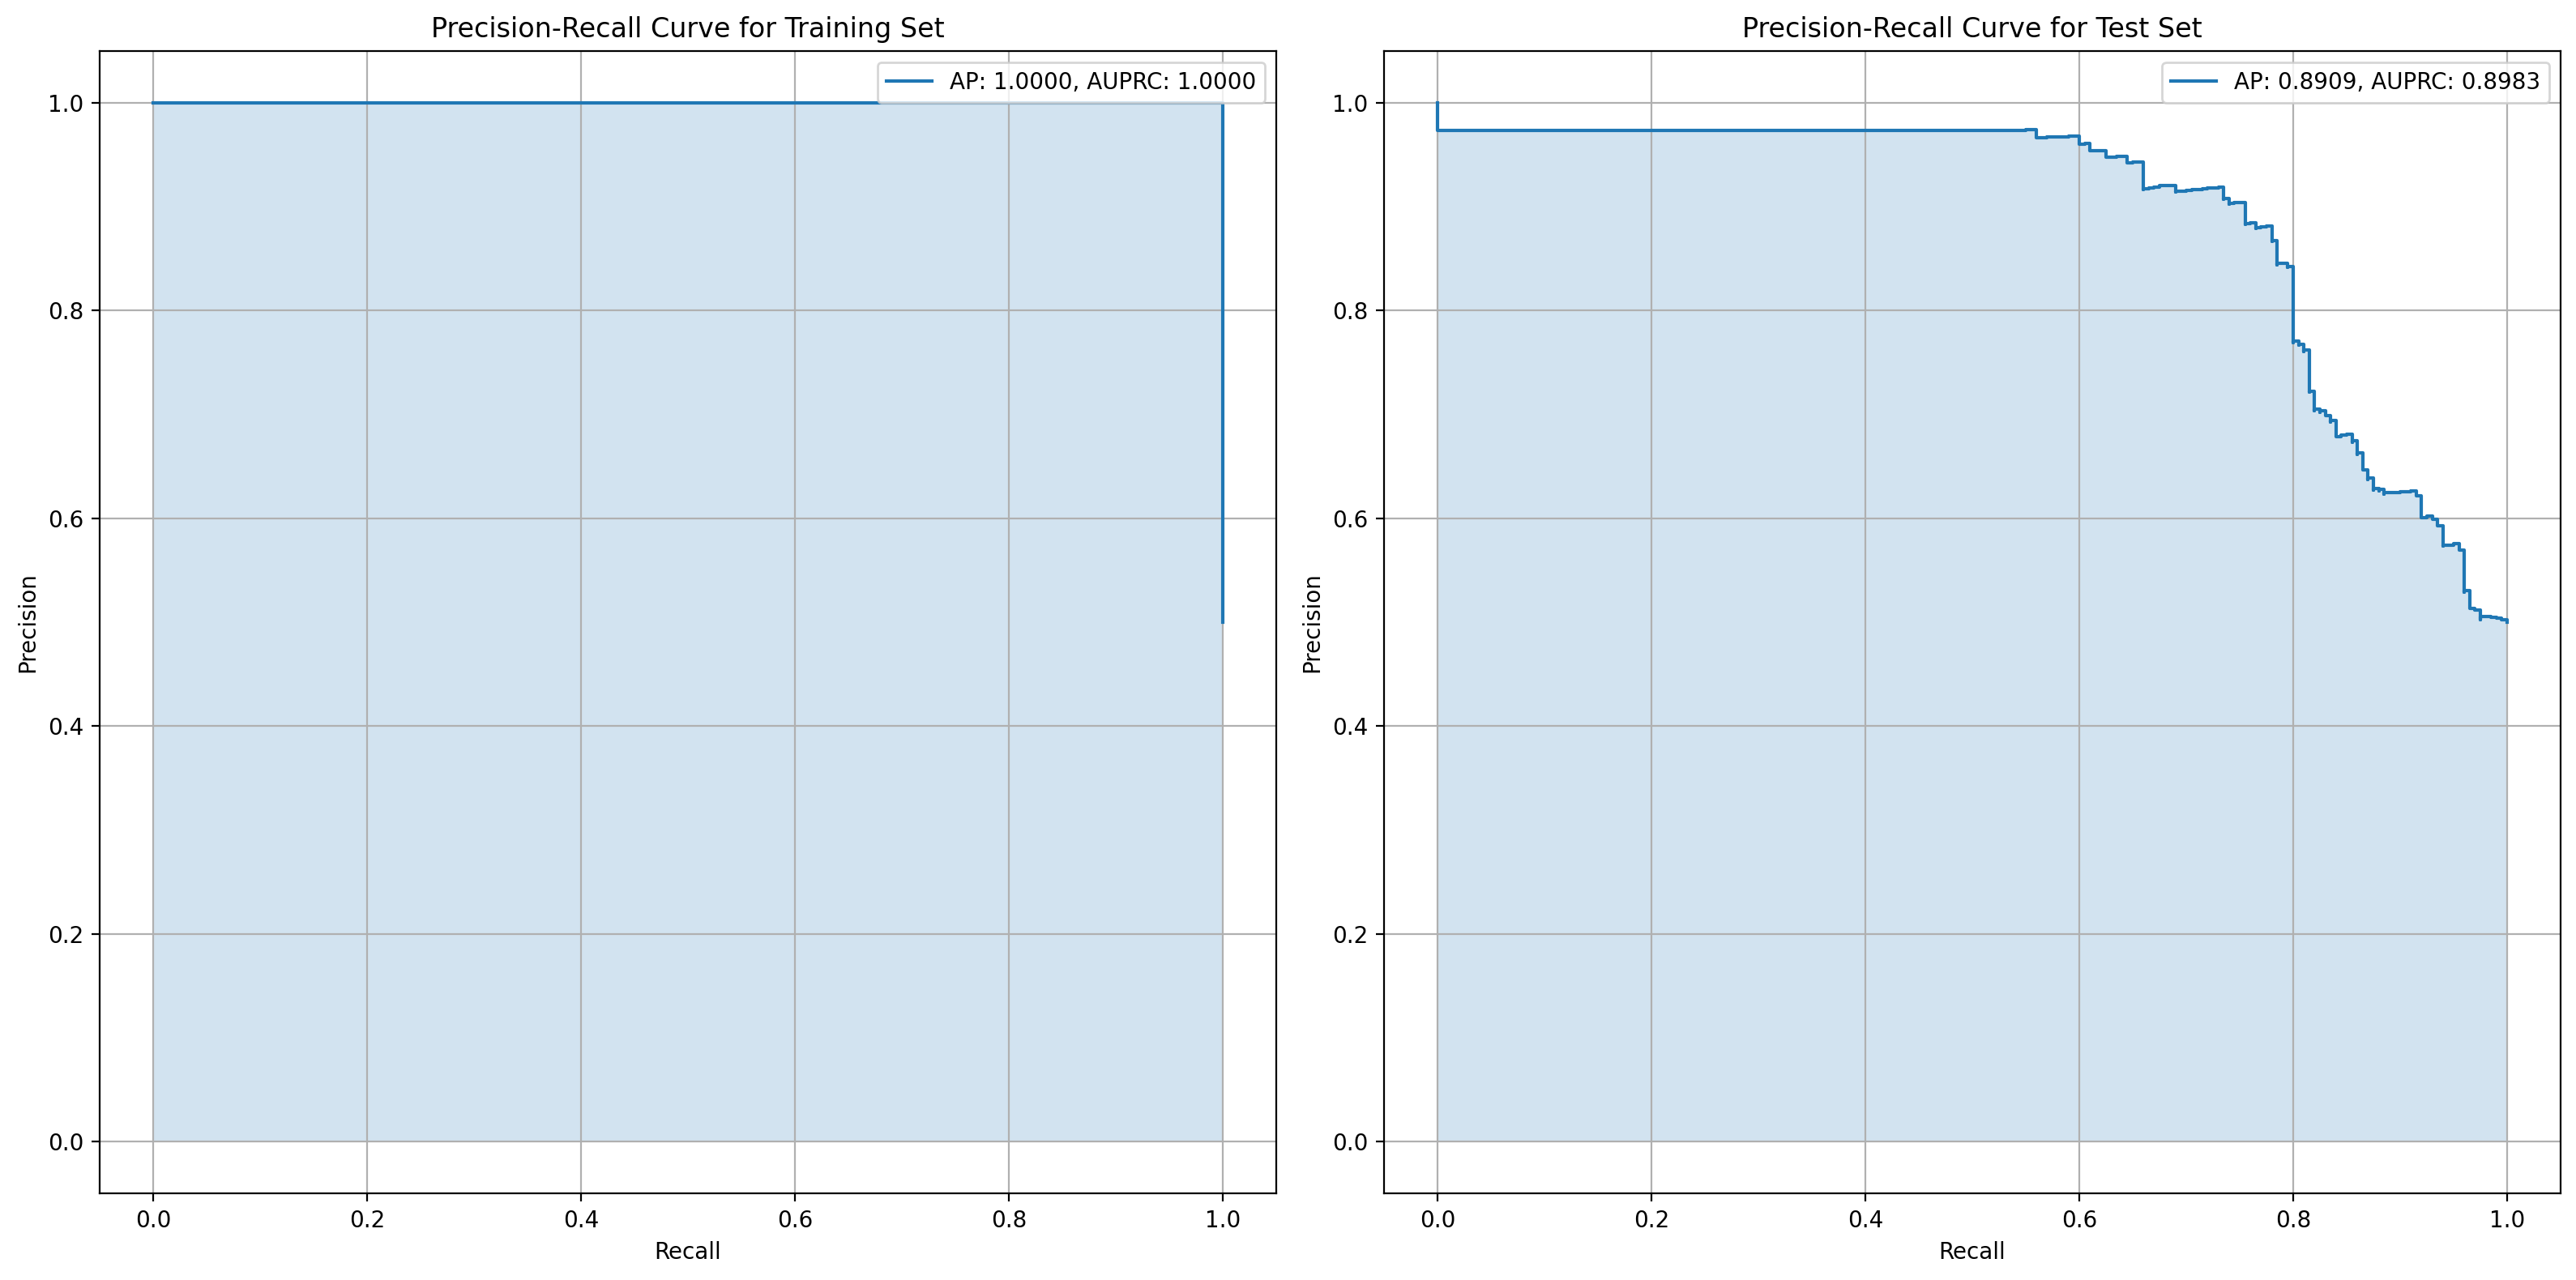

In [ ]:
# Calculate AUPRC for training and test sets
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

# Plotting the PR curves in subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Training PR curve
axs[0].step(recall_train, precision_train, where="post", label=f"AP: {average_precision_train:.4f}, AUPRC: {auprc_train:.4f}")
axs[0].fill_between(recall_train, precision_train, step="post", alpha=0.2)
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].set_title("Precision-Recall Curve for Training Set")
axs[0].legend(loc="upper right")
axs[0].grid(True)

# Testing PR curve
axs[1].step(recall_test, precision_test, where="post", label=f"AP: {average_precision_test:.4f}, AUPRC: {auprc_test:.4f}")
axs[1].fill_between(recall_test, precision_test, step="post", alpha=0.2)
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].set_title("Precision-Recall Curve for Test Set")
axs[1].legend(loc="upper right")
axs[1].grid(True)

plt.tight_layout()

# plt.savefig(f"{output_folder}/layer_1_pr_curves.pdf", format="pdf")
plt.show()


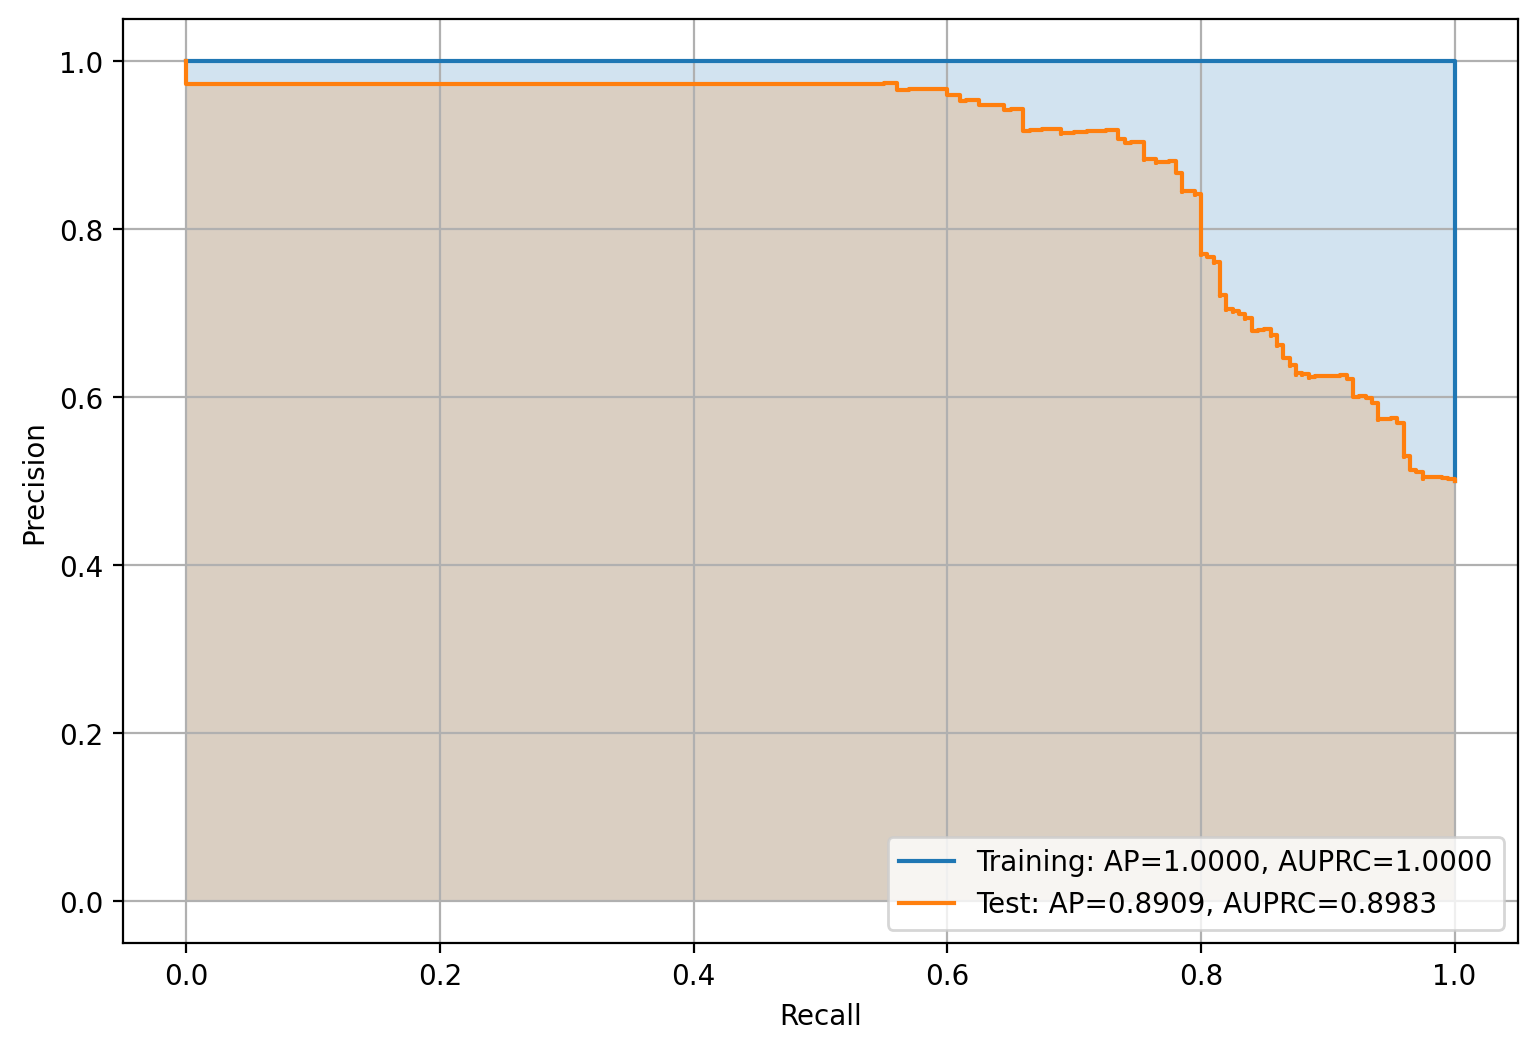

In [63]:
# Calculate AUPRC for training and test sets
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

# Plotting the PR curves
plt.figure(figsize=(9, 6))

# Training PR curve
plt.step(recall_train, precision_train, where="post", label=f"Training: AP={average_precision_train:.4f}, AUPRC={auprc_train:.4f}")
plt.fill_between(recall_train, precision_train, step="post", alpha=0.2)

# Test PR curve
plt.step(recall_test, precision_test, where="post", label=f"Test: AP={average_precision_test:.4f}, AUPRC={auprc_test:.4f}")
plt.fill_between(recall_test, precision_test, step="post", alpha=0.2)

# Plot settings
plt.xlabel("Recall")
plt.ylabel("Precision")
# plt.title("Precision-Recall Curve")
plt.legend(loc="lower right")
plt.grid(True)

plt.savefig(f"{output_folder}/layer_1_pr_curves.pdf", format="pdf", bbox_inches='tight')
plt.show()


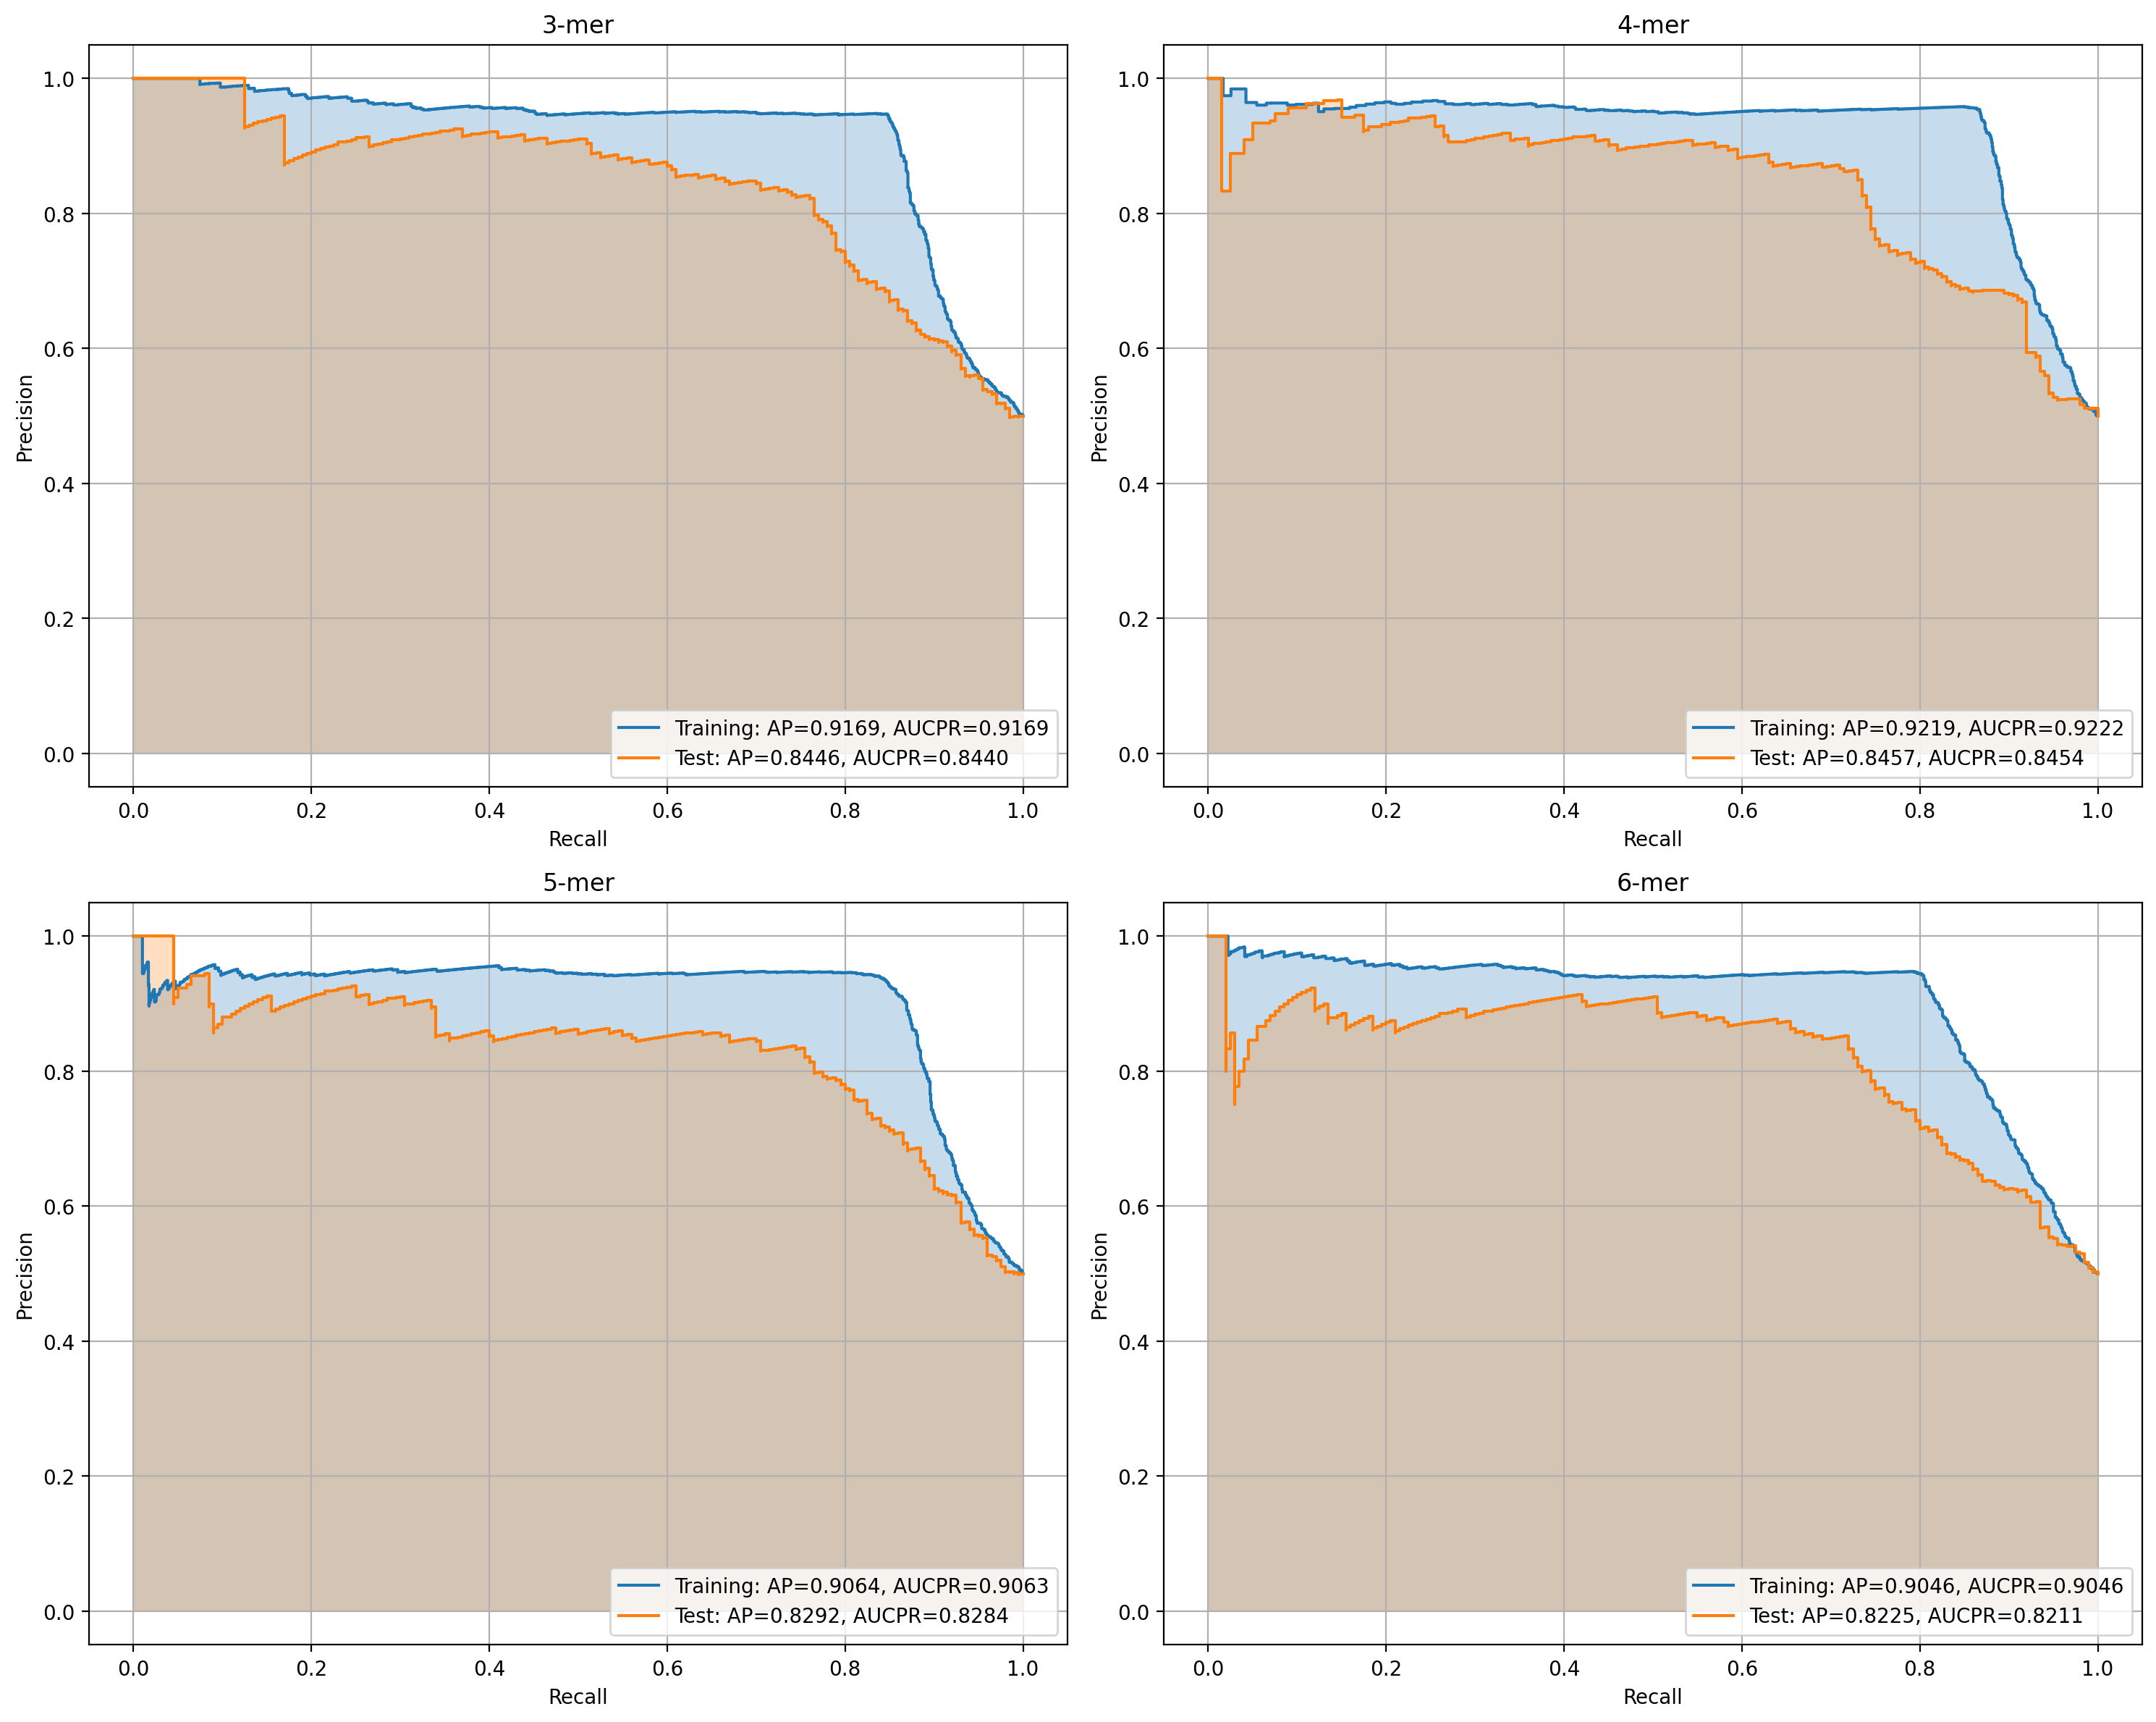

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # Create a figure with 2 rows and 2 columns

for i, mer in enumerate(kmer_values):
    # Calculate precision and recall for training data for the current k-mer
    precision_kmer_train, recall_kmer_train, _ = precision_recall_curve(train_labels_list[i], train_predictions_list[i])
    average_precision_kmer_train = average_precision_score(train_labels_list[i], train_predictions_list[i])
    aucpr_kmer_train = auc(recall_kmer_train, precision_kmer_train)

    # Calculate precision and recall for test data for the current k-mer
    precision_kmer_test, recall_kmer_test, _ = precision_recall_curve(test_labels_list[i], test_predictions_list[i])
    average_precision_kmer_test = average_precision_score(test_labels_list[i], test_predictions_list[i])
    aucpr_kmer_test = auc(recall_kmer_test, precision_kmer_test)

    # Determine the position of the subplot
    ax = axs[i // 2, i % 2]

    # Plot k-mer training PR curve
    ax.step(recall_kmer_train, precision_kmer_train, where="post", 
            label=f"Training: AP={average_precision_kmer_train:.4f}, AUCPR={aucpr_kmer_train:.4f}")
    ax.fill_between(recall_kmer_train, precision_kmer_train, step="post", alpha=0.25)

    # Plot k-mer test PR curve
    ax.step(recall_kmer_test, precision_kmer_test, where="post", 
            label=f"Test: AP={average_precision_kmer_test:.4f}, AUCPR={aucpr_kmer_test:.4f}")
    ax.fill_between(recall_kmer_test, precision_kmer_test, step="post", alpha=0.25)

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"{mer}-mer")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.tight_layout()
plt.savefig(f"{output_folder}/layer_1_kmer_pr_curves.pdf", format="pdf", bbox_inches='tight')
plt.show()

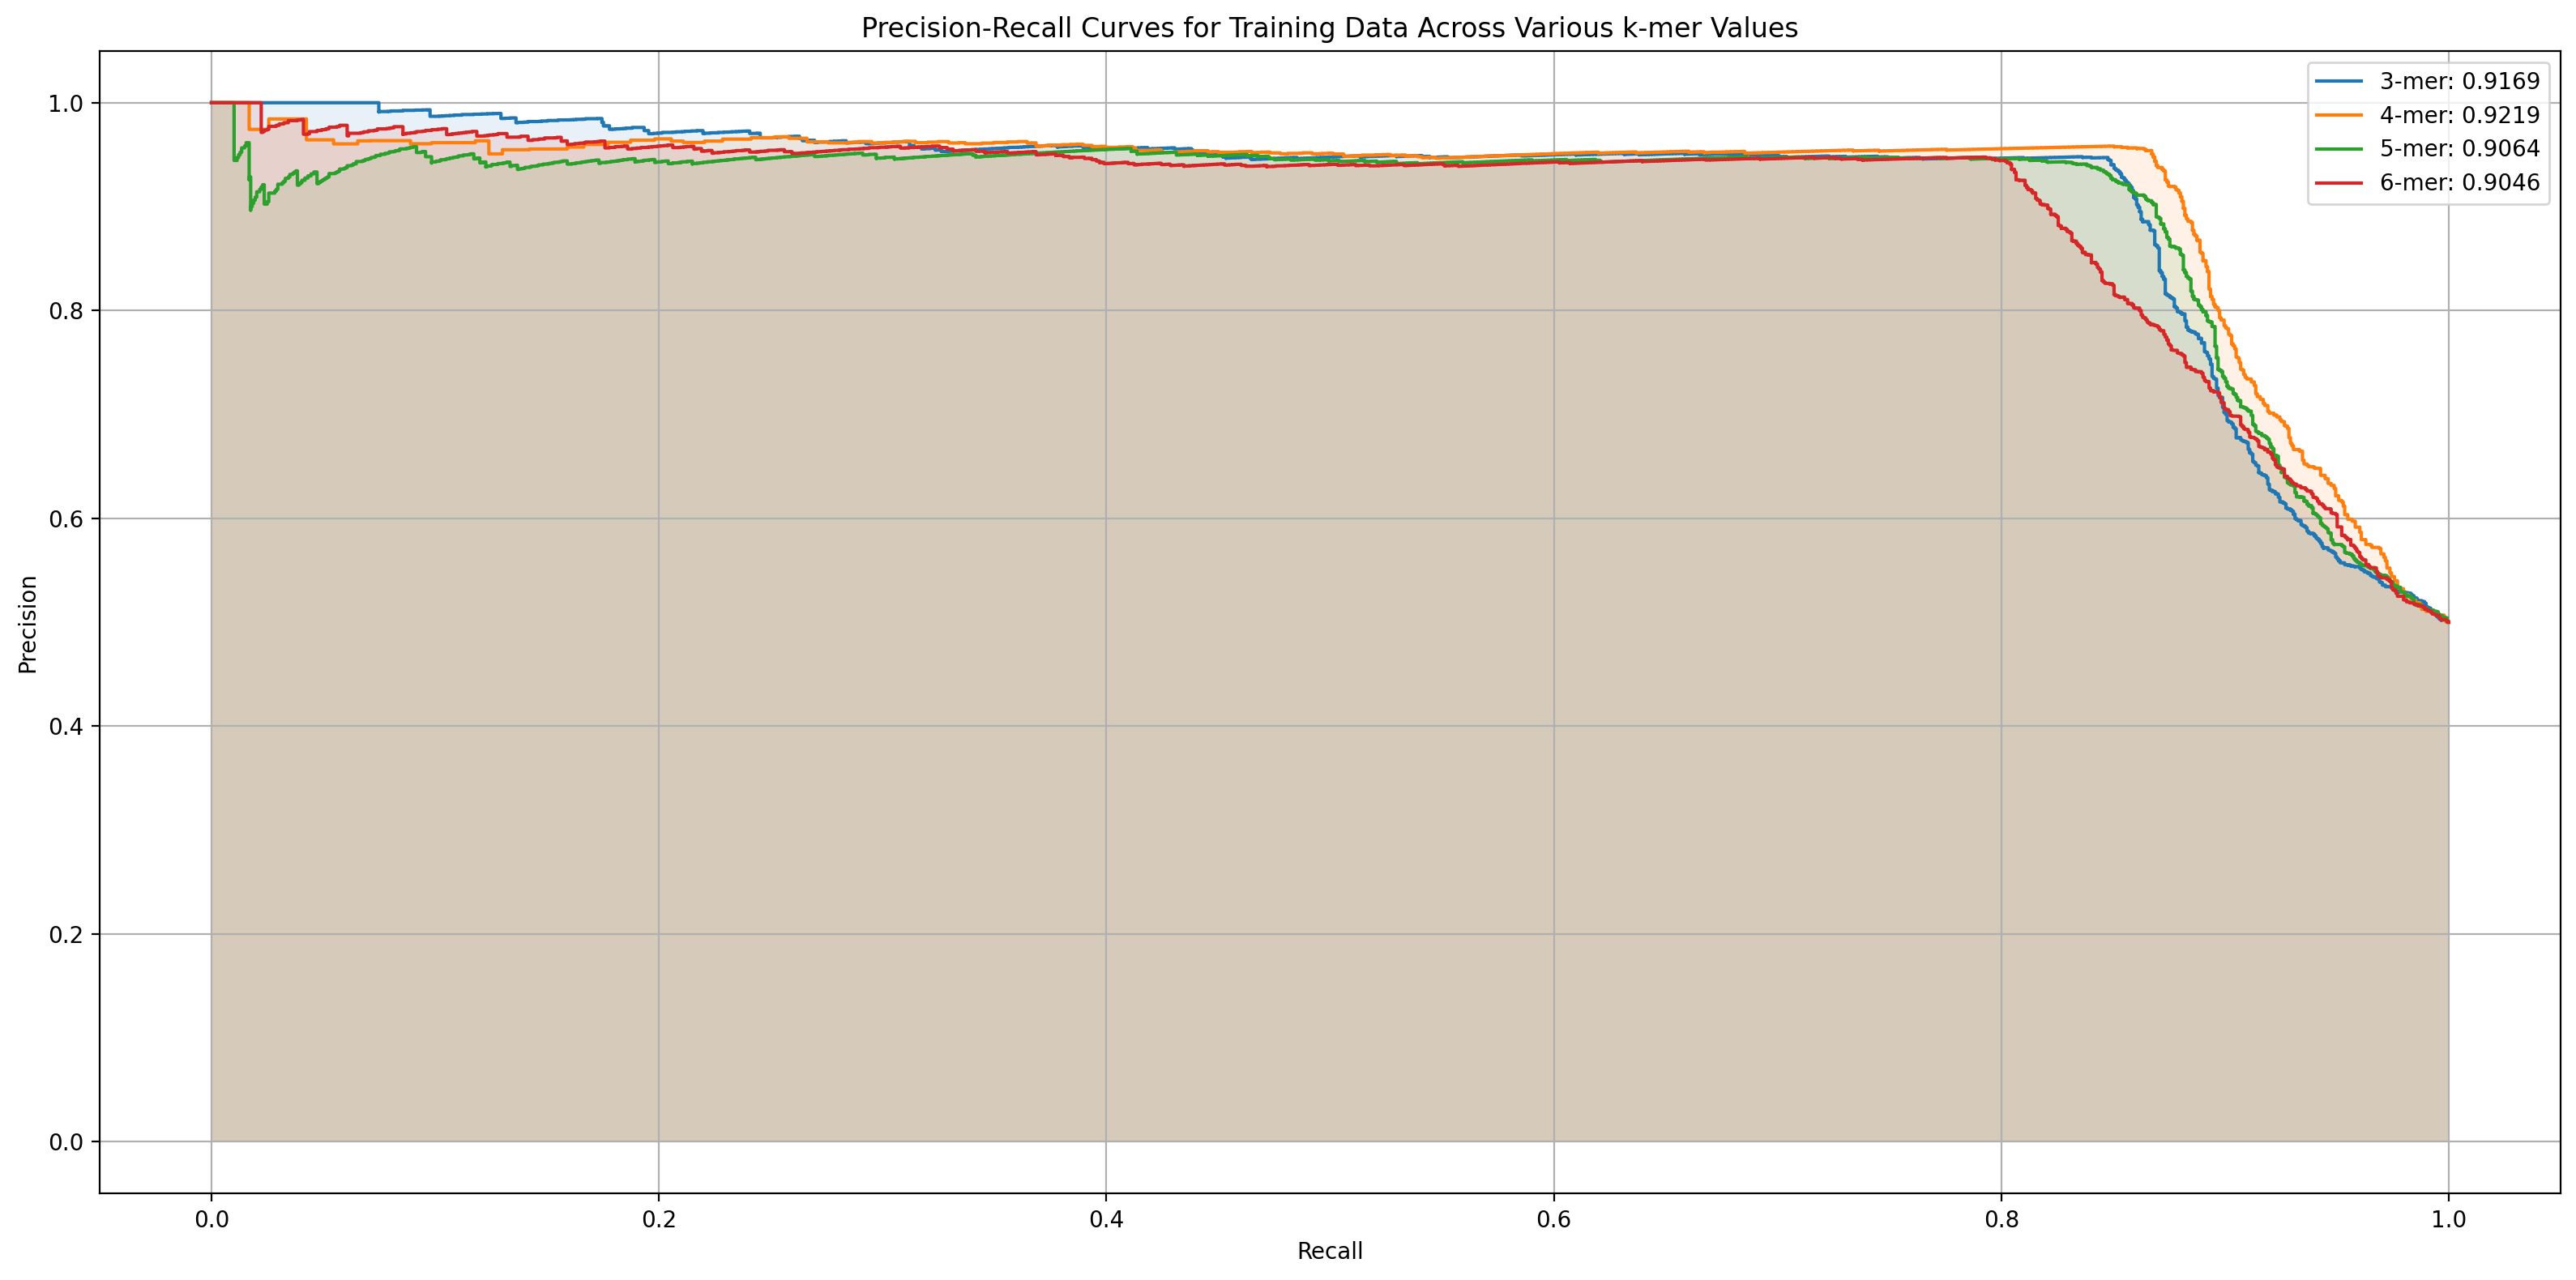

In [27]:
# Plot for training set
plt.figure(figsize=(16, 8))

for i, mer in enumerate(kmer_values):
    # Calculate precision and recall for training data
    precision_kmer_train, recall_kmer_train, _ = precision_recall_curve(train_labels_list[i], train_predictions_list[i])
    average_precision_kmer_train = average_precision_score(train_labels_list[i], train_predictions_list[i])

    # Add the PR curve to the training plot
    plt.step(recall_kmer_train, precision_kmer_train, where="post", label=f"{mer}-mer: {average_precision_kmer_train:.4f}")
    plt.fill_between(recall_kmer_train, precision_kmer_train, step="post", alpha=0.1)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Training Data Across Various k-mer Values")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

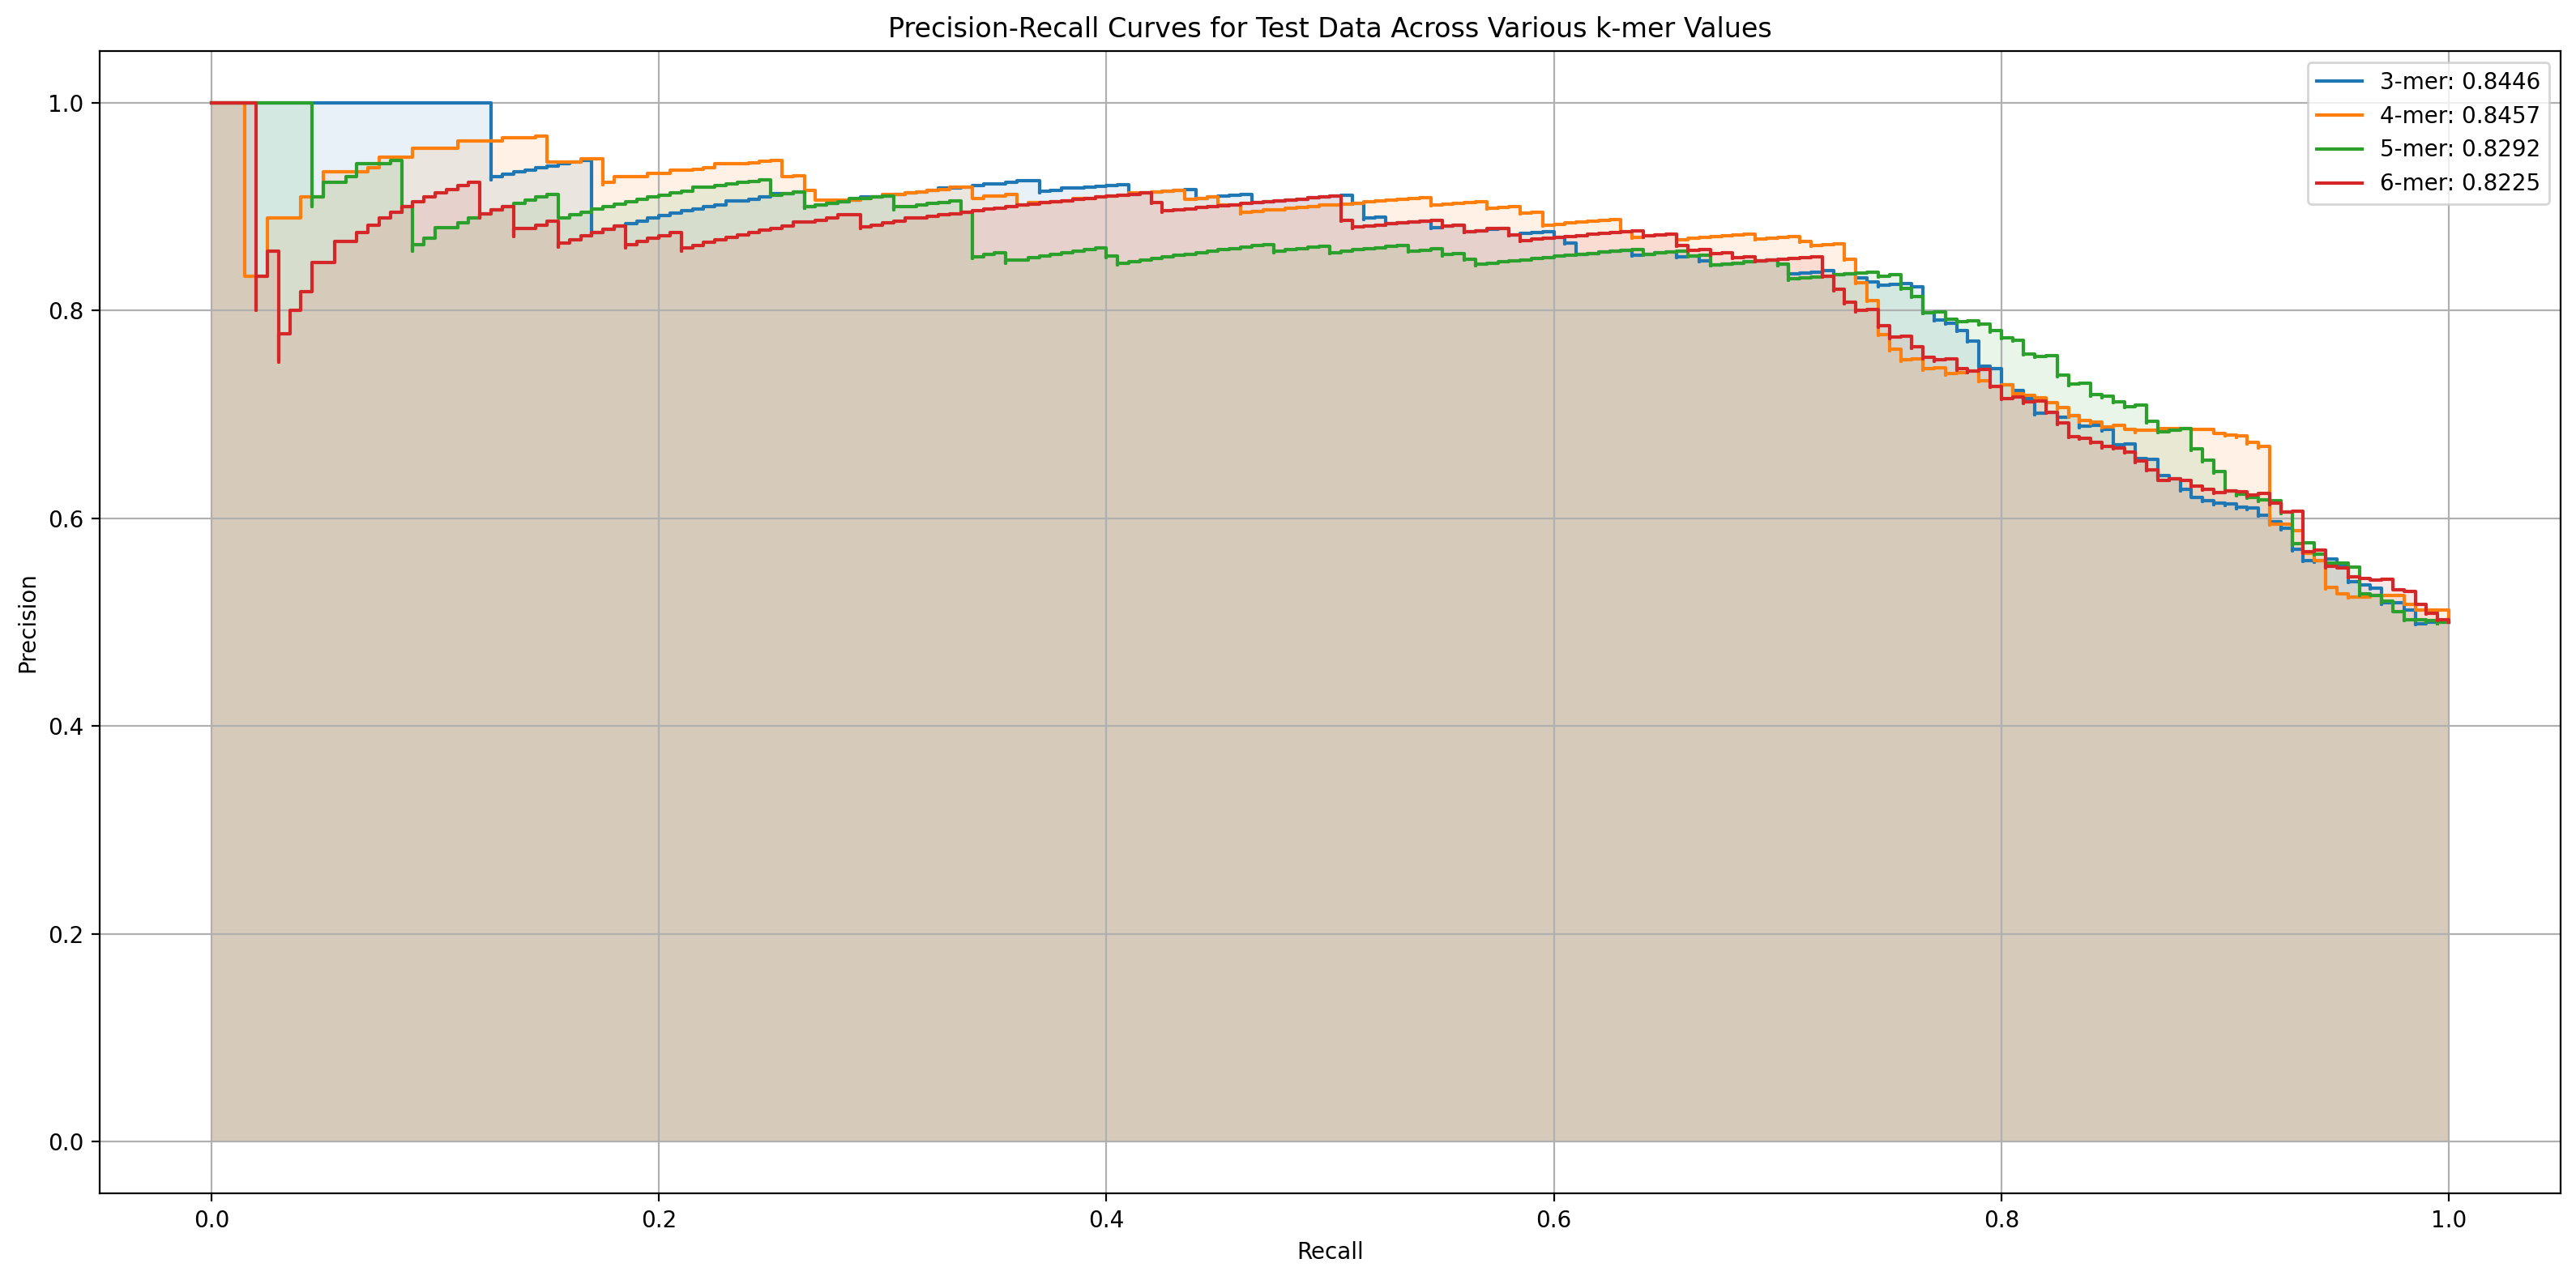

In [28]:

# Plot for test set
plt.figure(figsize=(16, 8))

for i, mer in enumerate(kmer_values):
    # Calculate precision and recall for test data
    precision_kmer_test, recall_kmer_test, _ = precision_recall_curve(test_labels_list[i], test_predictions_list[i])
    average_precision_kmer_test = average_precision_score(test_labels_list[i], test_predictions_list[i])

    # Add the PR curve to the test plot
    plt.step(recall_kmer_test, precision_kmer_test, where="post", label=f"{mer}-mer: {average_precision_kmer_test:.4f}")
    plt.fill_between(recall_kmer_test, precision_kmer_test, step="post", alpha=0.1)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Test Data Across Various k-mer Values")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()